# Lesson 2 - Random forest deep dive

> A deep dive into how Random Forests work and some tricks for making them more performant.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/lewtun/hepml/master?urlpath=lab/tree/notebooks%2Flesson02_random-forest-deep-dive.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lewtun/hepml/blob/master/notebooks/lesson02_random-forest-deep-dive.ipynb)

## Learning objectives

* Understand how to go from simple to complex models
* Understand the concepts of bagging and out-of-bag score
* Gain an introduction to hyperparameter tuning
* Understand how to interpret permutation feature importance plots for Random Forest models.

## References

* Chapters 6 & 7 of _Hands-On Machine Learning with Scikit-Learn and TensorFlow_ by Aurèlien Geron
* [Beware Default Random Forest Feature Importances](https://explained.ai/rf-importance/#experimental)
* [Searching for exotic particles in high-energy physics with deep learning](https://www.nature.com/articles/ncomms5308) by Baldi et al.

## The data

We will continue our analysis of the [SUSY dataset](http://archive.ics.uci.edu/ml/datasets/SUSY#) from lesson 1, but this time start from our prepared training and test sets:

* `susy_train.feather`
* `susy_test.feather`

By using the [Feather format](https://blog.rstudio.com/2016/03/29/feather/) we can load our data in a fraction of the time compared to CSV.

## Import libraries

In [2]:
# reload modules before executing user code
%load_ext autoreload
# reload all modules every time before executing Python code
%autoreload 2
# render plots in notebook
%matplotlib inline

In [4]:
# data wrangling
import pandas as pd
import numpy as np
from scipy import stats
from pathlib import Path
from hepml.core import display_large, download_dataset

# data viz
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix
from sklearn.tree import plot_tree

sns.set(color_codes=True)
sns.set_palette(sns.color_palette("muted"))

# ml magic
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance
import scipy
from scipy.cluster import hierarchy as hc

## Load the data

As usual, we can download our datasets by using our `download_dataset` helper function:

In [5]:
download_dataset("susy_train.feather")
download_dataset("susy_test.feather")

Dataset already exists at '../data/susy_train.feather' and is not downloaded again.
Dataset already exists at '../data/susy_test.feather' and is not downloaded again.


With pathlib it is a simple matter to define the filepath to the dataset, and since the file is in Feather format we can load it as a pandas.DataFrame as follows:

In [7]:
susy_train = pd.read_feather("../data/susy_train.feather")

In [9]:
susy_train.head()

,signal,lepton 1 pT,lepton 1 eta,lepton 1 phi,lepton 2 pT,lepton 2 eta,lepton 2 phi,missing energy magnitude,missing energy phi,MET_rel,axial MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos(theta_r1)
0,0.0,0.972861,0.653855,1.176225,1.157156,-1.739873,-0.874309,0.567765,-0.175000,0.810061,-0.252552,1.921887,0.889637,0.410772,1.145621,1.932632,0.994464,1.367815,0.040714
1,1.0,1.667973,0.064191,-1.225171,0.506102,-0.338939,1.672543,3.475464,-1.219136,0.012955,3.775174,1.045977,0.568051,0.481928,0.000000,0.448410,0.205356,1.321893,0.377584
2,1.0,0.444840,-0.134298,-0.709972,0.451719,-1.613871,-0.768661,1.219918,0.504026,1.831248,-0.431385,0.526283,0.941514,1.587535,2.024308,0.603498,1.562374,1.135454,0.180910
3,1.0,0.381256,-0.976145,0.693152,0.448959,0.891753,-0.677328,2.033060,1.533041,3.046260,-1.005285,0.569386,1.015211,1.582217,1.551914,0.761215,1.715464,1.492257,0.090719
4,1.0,1.309996,-0.690089,-0.676259,1.589283,-0.693326,0.622907,1.087562,-0.381742,0.589204,1.365479,1.179295,0.968218,0.728563,0.000000,1.083158,0.043429,1.154854,0.094859


In [10]:
susy_train.shape

(4500000, 19)

In [11]:
susy_test = pd.read_feather("../data/susy_test.feather")

In [12]:
susy_test.head()

,signal,lepton 1 pT,lepton 1 eta,lepton 1 phi,lepton 2 pT,lepton 2 eta,lepton 2 phi,missing energy magnitude,missing energy phi,MET_rel,axial MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos(theta_r1)
0,0.0,2.088279,1.556223,-1.159801,2.564809,0.640849,1.341437,1.096579,0.797625,1.381939,-0.200281,2.162097,1.809158,0.742538,2.594079,1.958922,2.399706,0.465633,0.199338
1,0.0,0.483154,0.293696,-0.272460,0.474080,0.062757,-0.867734,1.142362,0.696387,1.714826,-0.288509,0.403597,0.897979,1.974393,1.888550,0.474009,1.420682,1.107179,0.043890
2,0.0,0.653066,1.396558,1.325271,0.656052,-1.034418,1.701688,1.034030,-0.227895,1.552204,-0.720430,1.204290,1.152103,0.848940,2.422719,1.227968,1.856319,1.393933,0.059517
3,1.0,2.212137,0.083248,1.662411,2.775866,0.437338,-0.114064,0.358706,-1.055752,0.141371,0.469900,2.065994,0.905919,0.389112,0.000000,2.056065,0.234328,0.594752,0.060977
4,0.0,0.578197,-1.303118,-1.496069,0.608464,-1.493001,0.379941,1.005586,-0.598012,1.509509,-0.098402,0.495630,0.813985,1.457386,0.842825,0.565840,0.973772,1.370470,0.127417


In [13]:
susy_test.shape

(500000, 19)

## Baseline model

As a sanity check, let's see create our sample and see how our baseline model performs on the validation set:

In [17]:
susy_sample = susy_train.sample(n=100000, random_state=42)

X = susy_sample.drop("signal", axis =1)
y = susy_sample["signal"]

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Dataset split: {len(X_train)} train rows + {len(X_valid)} valid rows")

Dataset split: 80000 train rows + 20000 valid rows


In [19]:
model = RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42)

In [20]:
%time model.fit(X_train, y_train)

CPU times: user 4.53 s, sys: 5.43 ms, total: 4.54 s
Wall time: 824 ms


RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42)

In [28]:
def print_scores(fitted_model):
    res = {
        "Accuracy on train:":accuracy_score(fitted_model.predict(X_train), y_train),
        "ROC AUC on train:":roc_auc_score(
           y_train, fitted_model.predict_proba(X_train)[:,1]),
        "Accuracy on valid:":accuracy_score(fitted_model.predict(X_valid), y_valid),
        "ROC AUC on valid:":roc_auc_score(
        y_valid, fitted_model.predict_proba(X_valid)[:,1]),
    
    }
    if hasattr(fitted_model, "oob_score_"):
        res["OOB accuracy:"] = fitted_model.oob_score_

    for k, v in res.items():
        print(k, round(v, 3))

In [29]:
help(hasattr)

Help on built-in function hasattr in module builtins:

hasattr(obj, name, /)
    Return whether the object has an attribute with the given name.
    
    This is done by calling getattr(obj, name) and catching AttributeError.



In [30]:
print_scores(model)

Accuracy on train: 0.985
ROC AUC on train: 0.999
Accuracy on valid: 0.782
ROC AUC on valid: 0.84


As we found in lesson 1, this simple model achieves a ROC AUC score of 0.84 and falls short of the benchmark models by a few percent (see table):

<div style="text-align: center">
<img src='images/susy_benchmark.png'>
   <p style="text-align: center;"> <b>Figure reference:</b> https://www.nature.com/articles/ncomms5308 </p>
</div>


Let's build a model that is so simple that we can actually take a look at it. As we saw in lesson 1, a Random Forest is simply a forest of decision trees, so let's begin by looking at a single tree (called estimators in scikit-learn):


In [32]:
model = RandomForestClassifier(
    n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1, random_state=42
)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=3, n_estimators=1, n_jobs=-1,
                       random_state=42)

In the above we have fixed the following hyperparameters:

* `n_estimators = 1`: create a forest with one tree, i.e. a _decision tree_
* `max_depth = 3`: how deep or the number of "levels" in the tree
* `bootstrap = False`: this setting ensures we use the whole dataset to build the tree
* `n_jobs = -1`: this parallelises the computation over all CPU cores
* `random_state = 42`: this sets the random seed so our results are reproducible

Let's see how this simple model performs:

In [33]:
print_scores(model)

Accuracy on train: 0.742
ROC AUC on train: 0.78
Accuracy on valid: 0.74
ROC AUC on valid: 0.779


Unsurprisingly, this single tree yields worse predictions (ROC AUC 0.779) than our baseline with 10 trees (ROC AUC 0.840). Nevertheless, we can visualise the tree by accessing the `estimators_` attribute and making use of scikit-learn's plotting API ([link](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html)):

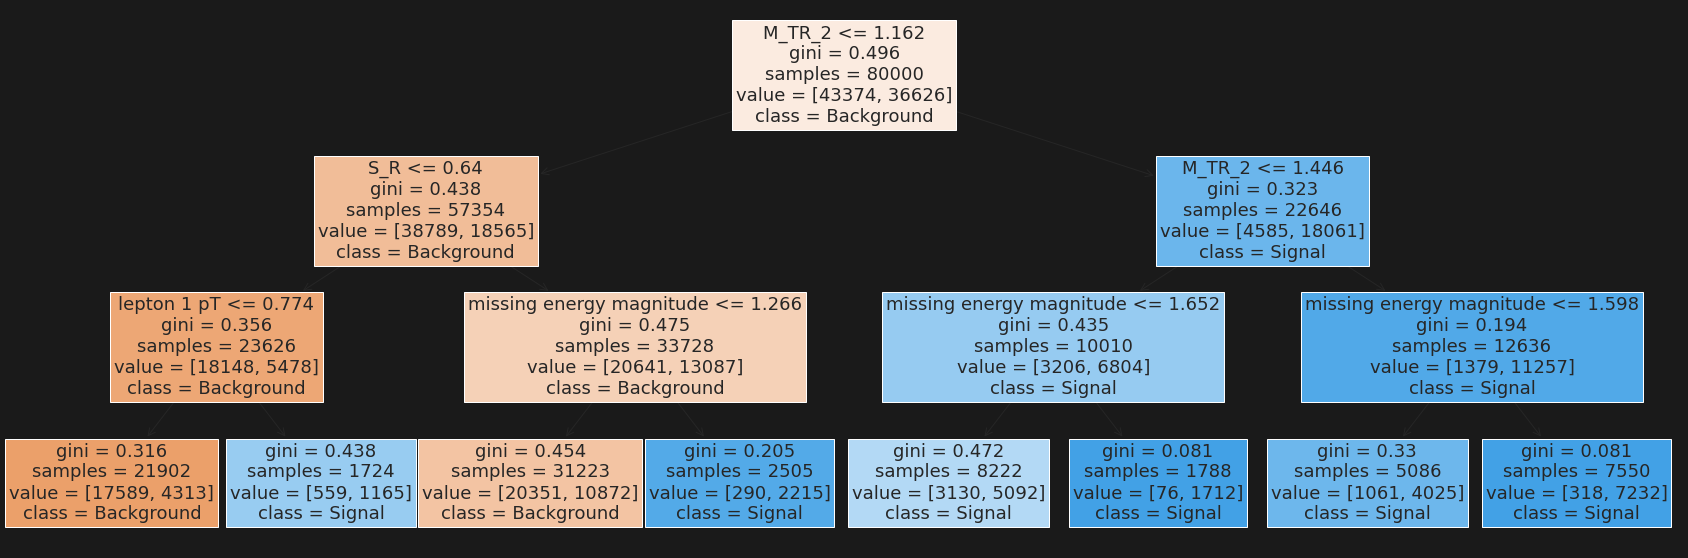

In [35]:
# get column names
feature_names = X_train.columns
# define class names
class_names = ["Background", "Signal"]
# we need to specify the background color because of a quirk in sklearn
fig, ax = plt.subplots(figsize=(30, 10), facecolor="k")
# generate tree plot
plot_tree(
    model.estimators_[0],
    filled=True,
    feature_names=feature_names,
    class_names=class_names,
    ax=ax,
    fontsize=18,
)
plt.show()

From the figure we observe that a tree consists of a sequence of binary decisions, where each box includes information about:

* The binary split criterion (mean squared error (mse) in this case)
* The number of `samples` in each node. Note we start with the full dataset in the root node and get successively smaller values at each split.
* Darker blues (oranges) indicate a higher amount of signal (background) events in the `value` attribute 
* The best single binary split is for `M_TR_2 <= 1.162` which reduces the Gini impurity from 0.496 in the root node to 0.438 (0.323) in the depth-1 left (right) node.

## Increasing the tree depth

Right now our simple tree model has an accuracy of 74.2% on the validation set - let's try to make better by removing the `max_depth=3` restriction:

In [36]:
model = RandomForestClassifier(
    n_estimators=1, bootstrap=False, n_jobs=-1, random_state=42
)
model.fit(X_train, y_train)


RandomForestClassifier(bootstrap=False, n_estimators=1, n_jobs=-1,
                       random_state=42)

In [37]:
print_scores(model)


Accuracy on train: 1.0
ROC AUC on train: 1.0
Accuracy on valid: 0.71
ROC AUC on valid: 0.708


Note that removing the `max_depth` constraint has yielded _perfect_ accuracy and ROC AUC scores on the training set! That is because in this case each leaf node has exactly one element, so we can perfectly segment the data. We also have an accuracy of ROC AUC score of 0.708 on the validation set which is worse than our shallow tree, so let's look at some techniques to improve it.

## Introduction to bagging

Bagging is a technique that can be used to improve the ability of models to generalise to new data.

The basic idea between bagging is to consider training _several_ models, each of which is only partially predictive, but crucially, uncorrelated. Since these models are effectively gaining different insights into the data, by averaging their predictions we can create an _ensemble_ that is more predictive!

As shown in the figure, bagging is a two-step process:

1. Bootstrapping, i.e. sampling the training set
2. Aggregation, i.e. averaging predictions from multiple models

This gives us the acronym Bootstrap AGGregatING, or bagging for short 🤓.

The key for this to work is to ensure the errors of each mode are uncorrelated, so the way we do that with trees is to _**sample with replacement**_ from the data: this produces a set of independent samples upon which we can train our models for the ensemble.
<div style="text-align: center">
<img src='./images/bagging.png' width='700'>
<p style="text-align: center;"> <b>Figure reference:</b> https://bit.ly/33tGPVT </p>
</div>

## Hyperparameter tuning


If we revisit our very first model, we saw that the number of trees (`n_estimators`) is one of the parameters we can tune when building our Random Forest. Let's look at this more closely and see how the performance of the forest improves as we add trees.

In [38]:
model = RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42)

After training, each tree is stored in an attribute called `estimators_`. For each tree, we can call `predict()` on the validation set and use the `numpy.stack()` function to concatenate the predictions together:

In [39]:
preds = np.stack([tree.predict_proba(X_valid)[:,1] for tree in model.estimators_])

Since we have 10 trees and 20,000 samples in our validation set, we expect that `preds` will have shape $(n_\mathrm{trees}, n_\mathrm{samples})$:

Let's now look at a plot of the AUC score as we increase the number of trees:

In [44]:
def plot_auc_vs_trees(preds, y_valid):
    """Generate a plot of accuracy on validation set vs number of trees in Random Forest"""
    fig, ax = plt.subplots()
    plt.plot(
        [
            roc_auc_score(y_valid, np.mean(preds[: i + 1], axis=0))
            for i in range(len(preds) + 1)
        ]
    )
    ax.set_ylabel("Accuracy on validation set")
    ax.set_xlabel("Number of trees")

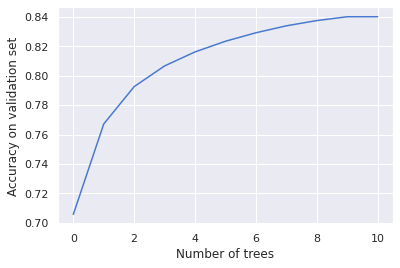

In [45]:
plot_auc_vs_trees(preds, y_valid)

As we add more trees, the AUC score improves but appears to flatten out. Let's test this numerically.



In [46]:
for n_estimators in [20, 40, 80, 160]:
    print(f"Number of trees: {n_estimators}\n")
    model = RandomForestClassifier(
        n_estimators=n_estimators, n_jobs=-1, random_state=42
    )
    model.fit(X_train, y_train)
    print_scores(model)
    print("=" * 50, "\n")


Number of trees: 20

Accuracy on train: 0.996
ROC AUC on train: 1.0
Accuracy on valid: 0.79
ROC AUC on valid: 0.855

Number of trees: 40

Accuracy on train: 0.999
ROC AUC on train: 1.0
Accuracy on valid: 0.794
ROC AUC on valid: 0.861

Number of trees: 80

Accuracy on train: 1.0
ROC AUC on train: 1.0
Accuracy on valid: 0.798
ROC AUC on valid: 0.865

Number of trees: 160

Accuracy on train: 1.0
ROC AUC on train: 1.0
Accuracy on valid: 0.799
ROC AUC on valid: 0.867



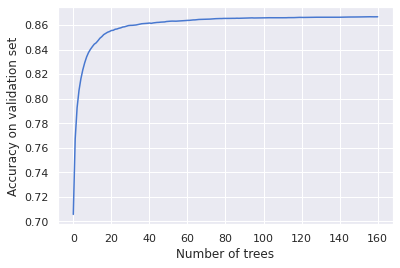

In [47]:
preds = np.stack([tree.predict_proba(X_valid)[:,1] for tree in model.estimators_])
plot_auc_vs_trees(preds, y_valid)

Adding more trees slows the computation down, so we can conclude from the plot that about 80 trees is a good number to gain good performance for cheaper compute.

## Out-Of-Bag (OOB) score

So far, we've been using a validation set to examine the effect of tuning hyperparameters like the number of trees - what happens if the dataset is small and it may not be feasible to create a validation set because you would not have enough data to build a good model? Random Forests have a nice feature called _**Out-Of-Bag (OOB) error**_ which is designed for just this case!

The key idea is to observe that the first tree of our ensemble was trained on a bagged sample of the full dataset, so if we evaluate this model on the _remaining_ samples we have effectively created a _validation set per tree._ To generate OOB predictions, we can then calculate the majority class of all the trees and calculate ROC AUC, accuracy, or whatever metric we are interested in.

To toggle this behaviour in scikit-learn, one makes use of the `oob_score` flag, which adds an `oob_score_` attribute to our model that we can print out:

In [48]:
model = RandomForestClassifier(
    n_estimators=80, n_jobs=-1, oob_score=True, random_state=42
)
model.fit(X_train, y_train)
print_scores(model)

Accuracy on train: 1.0
ROC AUC on train: 1.0
Accuracy on valid: 0.798
ROC AUC on valid: 0.865
OOB accuracy: 0.792


## More hyperparameter tuning

Let's look at a few more hyperparameters that can be tuned in a Random Forest.

### Minimum number of samples per leaf

The hyperparameter `min_samples_leaf` controls whether or not the tree should continue splitting a given node based on the number of samples in that node. By default, `min_samples_leaf = 1`, so each tree will split all the way down to a single sample, but in practice it can be useful to work with values 3, 5, 10, 25 and see if the performance improves.

In [49]:
for leaf_val in [1, 3, 5, 10, 25]:
    print(f"Leaf value: {leaf_val}", "\n")
    model = RandomForestClassifier(
        n_estimators=80, min_samples_leaf=leaf_val, n_jobs=-1, random_state=42,
    )
    model.fit(X_train, y_train)
    print_scores(model)
    print("=" * 50, "\n")

Leaf value: 1 

Accuracy on train: 1.0
ROC AUC on train: 1.0
Accuracy on valid: 0.798
ROC AUC on valid: 0.865

Leaf value: 3 

Accuracy on train: 0.962
ROC AUC on train: 0.997
Accuracy on valid: 0.799
ROC AUC on valid: 0.868

Leaf value: 5 

Accuracy on train: 0.919
ROC AUC on train: 0.985
Accuracy on valid: 0.8
ROC AUC on valid: 0.868

Leaf value: 10 

Accuracy on train: 0.87
ROC AUC on train: 0.958
Accuracy on valid: 0.799
ROC AUC on valid: 0.87

Leaf value: 25 

Accuracy on train: 0.83
ROC AUC on train: 0.92
Accuracy on valid: 0.8
ROC AUC on valid: 0.87



For this particular dataset, setting `min_samples_leaf = 25` improves our metrics on the validation set, so let's fix this parameter to that value.

### Maximum number of features per split

Another good hyperparameter to tune is `max_features`, which controls what _**random**_ number or fraction of _**columns**_ we consider when making a single split at a tree node. Here, the motivation is that we might have situations where a few columns in our data are highly predictive, so each tree will be biased towards picking the same splits and thus reduce the generalisation power of our ensemble. To counteract that, we can tune `max_features`, where good values to try are `1.0`, `0.5`, `log2`, or `sqrt`.

In [50]:
for max_feat in [0.5, 1.0, "log2", "sqrt"]:
    print(f"Max features: {max_feat}", "\n")
    model = RandomForestClassifier(
        n_estimators=80,
        min_samples_leaf=25,
        max_features=max_feat,
        n_jobs=-1,
        random_state=42,
    )
    model.fit(X_train, y_train)
    print_scores(model)
    print("=" * 50, "\n")

Max features: 0.5 

Accuracy on train: 0.836
ROC AUC on train: 0.926
Accuracy on valid: 0.801
ROC AUC on valid: 0.871

Max features: 1.0 

Accuracy on train: 0.839
ROC AUC on train: 0.929
Accuracy on valid: 0.8
ROC AUC on valid: 0.871

Max features: log2 

Accuracy on train: 0.83
ROC AUC on train: 0.92
Accuracy on valid: 0.8
ROC AUC on valid: 0.87

Max features: sqrt 

Accuracy on train: 0.83
ROC AUC on train: 0.92
Accuracy on valid: 0.8
ROC AUC on valid: 0.87



Going beyond the default setting of `max_features = 'sqrt'` does not appear to help much. Nevertheless, compared to our first naive model with just 10 trees and default settings, this model achieves a ROC AUC of 0.87 on the validation set - an improvement of around 4.5%! This improvement may not sound like much, but in practice these incremental improvements can translate into high impact when aggregated over many such decisions (e.g. for event processing).

## Permutation feature importance

Training a model that accurately predicts outcomes is great, but most of the time you don't just need predictions, you want to be able to interpret your model. To work out which features are most important for a model's predictions, scikit-learn provides a clever technique known as [permutation feature importance](https://scikit-learn.org/stable/modules/permutation_importance.html):

> The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled 1. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature. This technique benefits from being model agnostic and can be calculated many times with different permutations of the feature.

In [51]:
model = RandomForestClassifier(
    n_estimators=80,
    min_samples_leaf=25,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42,
)

model.fit(X_train, y_train)

result = permutation_importance(
    model, X_valid, y_valid, n_repeats=10, random_state=42, n_jobs=-1, scoring="roc_auc"
)
sorted_idx = result.importances_mean.argsort()

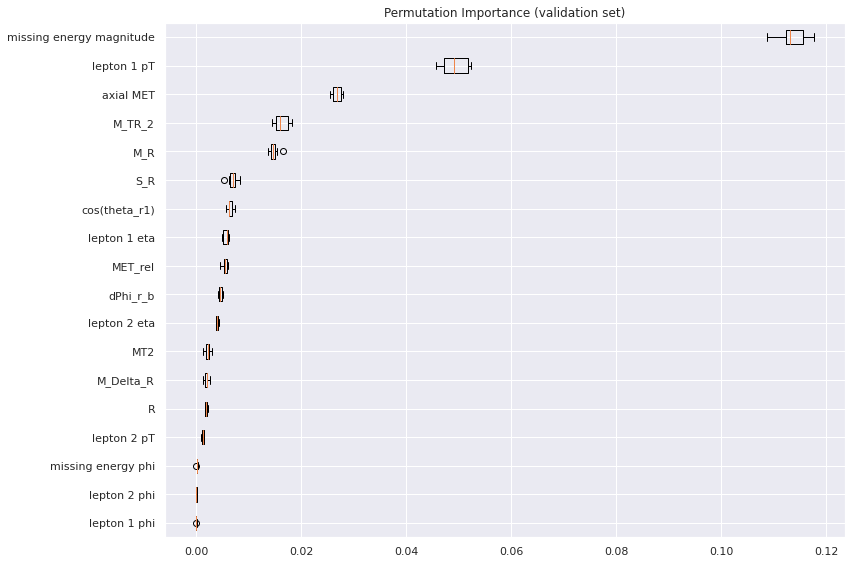

In [52]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=X_valid.columns[sorted_idx]
)
ax.set_title("Permutation Importance (validation set)")
fig.tight_layout()
plt.show()

From the plot we see the important features are a mix of the eight kinematic features, as well as ten hand-crafted features based on physics intuition. 

Consistent with the physics of these supersymmetric decays in the lepton channel, we find that the most informative features for classification are the:

* missing energy magnitude due to the neutralino
* the transverse momentum $p_T$ of one of the charged leptons
* missing transverse energy along the vector defined by the charged leptons (Axial MET) and

> Warning: in many applications of Random Forests, you will typically see a "feature importance" plot that is based on measuring which features reduce the Gini impurity on average. This technique is known to be _biased_ and can inflate the importance of numerical features with high cardinality. See https://explained.ai/rf-importance/#experimental

## Automate the boring stuff with randomized search

In our analysis above we manually inspected how the performance evolved when we changed the hyperparameters of the Random Forest one at a time. In practice, it can be better to automate this process using scikit-learn's `RandomizedSearchCV` to search for the best combination of hyperparameter values:

In [53]:
# define range of values for each hyperparameter
param_dist = [
    {
        "n_estimators": [10, 20, 40, 80, 160],
        "max_features": [0.5, 1.0, "sqrt", "log2"],
        "min_samples_leaf": [1, 5, 10, 25],
    }
]

# instantiate baseline model
model = RandomForestClassifier(n_estimators=10, n_jobs=-1)

# initialise random search with cross-validation
random_search = RandomizedSearchCV(
    model, param_distributions=param_dist, cv=5, scoring="roc_auc", n_jobs=-1
)

In [54]:
# this is a RAM hungry monster, so best fed on a laptop!
%time random_search.fit(X, y)

CPU times: user 1min 28s, sys: 220 ms, total: 1min 29s
Wall time: 3min 57s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_estimators=10, n_jobs=-1),
                   n_jobs=-1,
                   param_distributions=[{'max_features': [0.5, 1.0, 'sqrt',
                                                          'log2'],
                                         'min_samples_leaf': [1, 5, 10, 25],
                                         'n_estimators': [10, 20, 40, 80,
                                                          160]}],
                   scoring='roc_auc')

Once the search is finished, we can get the best combination of parameters as follows:

In [55]:
random_search.best_params_

{'n_estimators': 80, 'min_samples_leaf': 25, 'max_features': 0.5}

We can also examine the evaluation scores as follows:

In [56]:
cv_results = random_search.cv_results_

for score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
    print(f"{score:.3f}", params)

0.865 {'n_estimators': 80, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
0.867 {'n_estimators': 40, 'min_samples_leaf': 5, 'max_features': 'sqrt'}
0.866 {'n_estimators': 40, 'min_samples_leaf': 5, 'max_features': 'log2'}
0.867 {'n_estimators': 20, 'min_samples_leaf': 25, 'max_features': 'log2'}
0.854 {'n_estimators': 20, 'min_samples_leaf': 1, 'max_features': 'log2'}
0.870 {'n_estimators': 80, 'min_samples_leaf': 25, 'max_features': 0.5}
0.841 {'n_estimators': 10, 'min_samples_leaf': 1, 'max_features': 1.0}
0.866 {'n_estimators': 40, 'min_samples_leaf': 5, 'max_features': 0.5}
0.861 {'n_estimators': 40, 'min_samples_leaf': 1, 'max_features': 0.5}
0.865 {'n_estimators': 20, 'min_samples_leaf': 10, 'max_features': 1.0}


Now that we've tweaked our model's parameters, let's evaluate the final model on the test set. Here we just need the best model, and to evaluate it's predictions on the test set:

In [57]:
# select best model from randomised search
best_model = random_search.best_estimator_

# define features and target for test set
X_test, y_test = susy_test.drop("signal", axis=1), susy_test["signal"]

# calculate probabilities per class
probs = best_model.predict_proba(X_test)[:, 1]

# evaluate against ground truth
roc_auc_score(y_test, probs)

0.8707972350152826

The performance is compatible with that on the validation set, which suggests we have managed to not overfit! Compared to the benchmark models in the original article, our model is now better than the Boosted Decision Tree and with 0.5-1% of the (deep) neural networks - not bad!

## Exercises

* Use the techniques in this lesson to build Random Forest models for the "low-level" and "high-level" set of features. How do their ROC AUC scores compare against the table above?
* Randomised search is not guaranteed to find the _best_ set of hyperparameters, so for an exhaustive search one should use [grid search](https://scikit-learn.org/stable/modules/grid_search.html). To reduce the computational overhead, use the results from randomised search to reduce the parameter space and then launch a grid search to select the optimal features within this space.
* Use the optimal features either from randomised or grid search to train a Random Forest from scratch on the whole training set `susy_train` and evaluate its predictions on `susy_test`. You may want to increase `n_estimators` to get slightly higher performance. With 4.5 million events to train on, this step is best done with the computational resources of your desktop or laptop!